In [1]:
import torch
import matplotlib.pyplot as plt
from torch import optim, distributions, nn
from tqdm.notebook import tqdm
from gpzoo.gp import SVGP, VNNGP
from gpzoo.kernels import NSF_RBF, RBF
from gpzoo.likelihoods import GaussianLikelihood, NSF2
import squidpy as sq
import numpy as np
from gpzoo.utilities import train, deviancePoisson, rescale_spatial_coords, anndata_to_train_val, regularized_nmf, add_jitter
import gpzoo.pri_experiment_utilities as putil
import time
import scanpy as sc
import random
from os import path
from math import ceil
from copy import deepcopy
from scipy import sparse
from contextlib import suppress
from scanpy import read_h5ad
from tensorflow import constant
from tensorflow.data import Dataset
from sklearn.cluster import KMeans
from scipy.stats import poisson
from scipy.sparse import issparse


/engelhardt/home/pshrestha/vnngp/GPzoo/gpzoo/utilities.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
2024-07-03 13:04:15.936920: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-03 13:04:15.983113: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-03 13:04:16.518431: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
random.seed(256)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
dtp = "float32"
root_path = '/engelhardt/home/pshrestha/vnngp'
dpth = path.join(root_path, "data/")
mpth = path.join(root_path, "models/")
rpth = path.join(root_path, "results/")
slideseq_pth = path.join(rpth, "slideseq/")

In [4]:
def center_data(Dtr_n,Dval_n=None):
  Dtr_c = deepcopy(Dtr_n)
  feature_means=Dtr_c["Y"].mean(axis=0)
  Dtr_c["Y"] -= feature_means
  if Dval_n:
    Dval_c = deepcopy(Dval_n)
    Dval_c["Y"] -= feature_means
  else:
    Dval_c = None
  return feature_means,Dtr_c,Dval_c

def prepare_datasets_tf(Dtrain,Dval=None,shuffle=False,batch_size=None):
  """
  Dtrain and Dval are dicts containing numpy np.arrays of data.
  Dtrain must contain the key "Y"
  Returns a from_tensor_slices conversion of Dtrain and a dict of tensors for Dval
  """
  Ntr = Dtrain["Y"].shape[0]
  if batch_size is None:
    #ie one batch containing all observations by default
    batch_size = Ntr
  else:
    batch_size = minibatch_size_adjust(Ntr,batch_size)
  Dtrain = Dataset.from_tensor_slices(Dtrain)
  if shuffle:
    Dtrain = Dtrain.shuffle(Ntr)
  Dtrain = Dtrain.batch(batch_size)
  if Dval is not None:
    Dval = {i:constant(Dval[i]) for i in Dval}
  return Dtrain, Ntr, Dval

def scanpy_sizefactors(Y):
  sz = Y.sum(axis=1,keepdims=True)
  return sz/np.median(sz)

def heatmap(X,y,figsize=(6,4),bgcol="gray",cmap="turbo",**kwargs):
  fig,ax=plt.subplots(figsize=figsize)
  ax.set_facecolor(bgcol)
  ax.scatter(X[:,0],X[:,1],c=y,cmap=cmap,**kwargs)
  # fig.show()

def deviance_feature_selection(Y, fam="poisson"):
    if issparse(Y):
        Y = Y.toarray()
    feature_sums = Y.sum(axis=0)
    sz = Y.sum(axis=1)
    deviance = np.zeros(Y.shape[1])
    for i in range(Y.shape[1]):
        if feature_sums[i] == 0:
            continue
        if fam == "poisson":
            with np.errstate(divide='raise'):
                try:
                    ll_null = feature_sums[i] * np.log(feature_sums[i] / sz.sum())
                    ll_alt = Y[:, i] * np.log(Y[:, i] / sz) - Y[:, i] + ll_null
                    deviance[i] = 2 * (ll_alt.sum() - ll_null)
                except FloatingPointError:
                    deviance[i] = 0
    return deviance

In [5]:
dtp = "float32"
root_path = "/engelhardt/home/pshrestha/vnngp/"
dpth = path.join(root_path, "data/")
original_path = path.join(dpth, "original")
mpth = path.join(root_path, "models/")
rpth = path.join(root_path, "results/")
visium_pth = path.join(rpth, "paper_visium/")

if not path.exists(original_path):
    makedirs(original_path)

In [6]:
X, Y = putil.load_slideseq()

/engelhardt/home/pshrestha/anaconda3/envs/vnngp/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:158: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_counts"] = number


In [7]:
X = np.array(X)

In [8]:
X_scaled = rescale_spatial_coords(X)

In [9]:
X = torch.Tensor(X)

In [10]:
def build_model(X, Y, loadings=None, factors=None, model_type=None, **kwargs):
    """
    Parameters:
    X:
        - torch.Size([N, D])
    Y:
        - torch.Size([L, N])
    loadings:
        - torch.Size([L, K])
    factors:
        - torch.Size([N, L])
    """
    V = scanpy_sizefactors(Y.T)
    #X = torch.tensor(X).type(torch.float).to(device)
    #Y = torch.tensor(Y).type(torch.float).to(device)
    kwargs = kwargs['kwargs']

    kmeans = putil.inducing_points_cluster_centers(X, kwargs['M'], random_state=kwargs['rs'])
    Z = nn.Parameter(torch.tensor(kmeans.cluster_centers_).type(torch.float))
    kernel = NSF_RBF(L=kwargs['L'], sigma=kwargs['sigma'], lengthscale=kwargs['lengthscale'])
    
    gp = None
    if model_type == 'VNNGP':
        gp = VNNGP(kernel, M=kwargs['M'], jitter=kwargs['jtr'], K=kwargs['K'])
    elif model_type == 'SVGP':
        gp = SVGP(kernel, M=kwargs['M'], jitter=kwargs['jtr'])

    X = torch.tensor(X).type(torch.float)
    Y = torch.tensor(Y).type(torch.float)
    Kzx = kernel.forward(Z.to('cpu'), X.to('cpu'))
    Kxz = torch.transpose(Kzx, -2, -1)
    Kzz = kernel.forward(Z, Z)

    all_factors = torch.tensor(factors.T)[:, :, None].type(torch.float)
    #print(Kzx @ Kxz)
    L1 = torch.linalg.cholesky(add_jitter(Kzx @ Kxz, 1e-1)) # changed from 1e-4 to 1e-3
    
    solved1 = torch.cholesky_solve(Kzx @ all_factors, L1)
    mu = (Kzz @ solved1).to(device)
    gp.mu = nn.Parameter(torch.squeeze(mu).clone().detach()).type(torch.float)
    Lu = 1e-2 * torch.eye(kwargs['M']).expand(kwargs['L'], kwargs['M'], kwargs['M'])
    gp.Lu = nn.Parameter(Lu.clone().detach())
    
    gp.Z = nn.Parameter(Z, requires_grad=False)

    model = NSF2(gp, Y, L=kwargs['L'])

    if loadings is not None:
        model.W = nn.Parameter(torch.tensor(putil.init_softplus(loadings)[:, :kwargs['L']]).type(torch.float))
    model.V = nn.Parameter(torch.squeeze(torch.tensor(putil.init_softplus(V)).type(torch.float)))
    model.to(device)
    return model

In [11]:
#L = [10, 15, 5, 8, 12]
L = [10]
#M = [500, 1000, 2000, 3000, 5000]
M = [3000]
#K = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
K = [8]
lkzz_builds = [1]
sigmas = [1.0, 2.0, 3.0]
#sigmas = [1.0]
lengthscales = [3.0, 5.0, 7.0, 9.0]

In [12]:
model_type = 'VNNGP'
steps = 500
batched = True
NMF = True
nmf_path = path.join(root_path, f"results/slideseq/nmf/nmf_factors_iter=10000_rs=256_L={10}.pt")
factors, loadings = putil.preloaded_nmf_factors("/engelhardt/home/pshrestha/vnngp/results/slideseq/nmf/nmf_factors_iter=10000_rs=256_L=10.pt")
X, Y = putil.load_slideseq()
X = np.array(X)
Y = np.array(Y)
moran_idx, moranI = putil.dims_autocorr(factors, X)
#factors=factors[:, moran_idx]
#loadings=loadings[:, moran_idx]

/engelhardt/home/pshrestha/anaconda3/envs/vnngp/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:158: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_counts"] = number


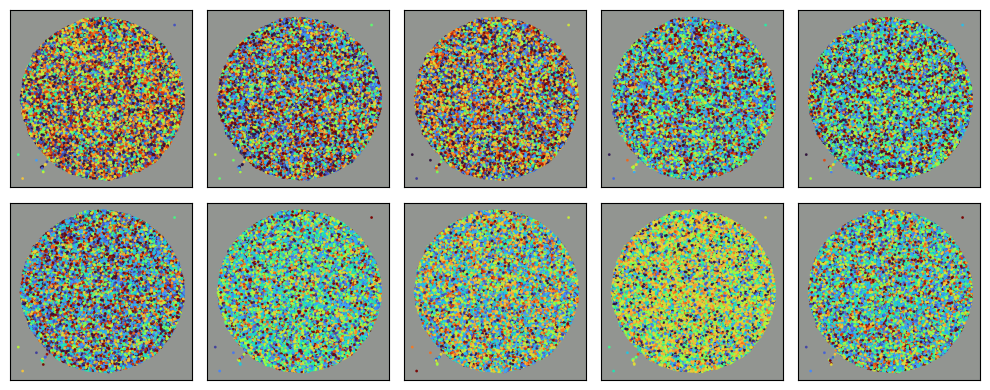

In [13]:
size=2
X = np.array(X)
fig, axes = plt.subplots(2, 5, figsize=(size*5, size*2), tight_layout=True)
putil.plot_factors(factors.T, X, moran_idx=moran_idx, size=2, s=1.0, alpha=0.9, ax=axes)

In [14]:
for s in sigmas:
    for l in lengthscales:
        dicts = {
            'L': 10, 
            'M': 3000, 
            'K': 8,
            'sigma': s, 
            'lengthscale': l, 
            'jtr': 1e-1,
            'batch_size': 128,
            'lr': 1e-3,
            'rs': 256,
            'lkzz_build': 1,
        }
        
        #X, Y = putil.load_slideseq()
        #X = np.array(X)
        #X_scaled = rescale_spatial_coords(X)
        #X = torch.tensor(X)
        X = np.array(X)
        Y = np.array(Y)
        
        kwargs = dicts
        file_path = model_type
        #X, Y = data_func()
        #K=None
        #if model_type == 'VNNGP':
            #K=kwargs['K']
            #file_path += f"_K={kwargs['K']}"
        
            #if kwargs['lkzz_build']:
                #file_path += f"_lkzz={kwargs['lkzz_build']}"
                
        #file_path += f"_M={kwargs['M']}_L={kwargs['L']}_lr={kwargs['lr']}_jtr={kwargs['jtr']}_iter={steps}"
        #if batched:
            #file_path += f"_bs={kwargs['batch_size']}"
            
        if NMF:
            # with NMF initialization
            file_path += f"_NMFinit"
            #X = np.array(X)
            #moran_idx, moranI = putil.dims_autocorr(factors, X)
            #factors=factors[:, moran_idx]
            #loadings=loadings[:, moran_idx]
            model = build_model(X, Y, loadings=loadings, factors=factors, model_type=model_type, kwargs=kwargs)
                
        #model = build_model(X, Y, loadings=loadings, factors=factors, model_type=model_type, kwargs=kwargs)
        putil.model_grads(model)
        model.prior.jitter=kwargs['jtr']
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=kwargs['lr'])
            
        model.to(device)
        X = torch.tensor(X).type(torch.float)
        Y = torch.tensor(Y).type(torch.float)
        X_train = X.to(device)
        #Y_train = Y.to(device)
            
        #start_time = time.time()
        losses, means, scales, idxs = putil.train_new_KL_batched(model, optimizer, X_train, Y, device,
                                                    steps=steps, E=3, batch_size=kwargs['batch_size'])
        #end_time = time.time()
            
        #final_time = end_time - start_time
            
        #torch.save(model.state_dict(), f'{save_path}/{file_path}_state_dict.pth')
        #torch.save({'losses': losses,
                    #'means': means,
                    #'scales': scales,
                    #'time': final_time},
                     #f'{save_path}/{file_path}_model.pt')
        
        print('sigmas:', model.prior.kernel.sigma)
        print('lengthscale:', model.prior.kernel.lengthscale)
        
        fig, ax = plt.subplots()
        ax.plot(losses)
        fig.suptitle(f"{model_type} Loss | sigma: {kwargs['sigma']}, lengthscale: {kwargs['lengthscale']}")
        plt.show()
            #fig.savefig(f'{save_path}/{file_path}_loss.png')
            #fig.close()
        
        size=2
        fig, axes = plt.subplots(2, 5, figsize=(size*5, size*2), tight_layout=True)
            
        model.cpu()
        qF, _, _ = model.prior(X)
        mean = torch.exp(qF.mean).detach().numpy()
        putil.plot_factors(np.exp(mean), X, moran_idx=moran_idx, size=2, s=1, alpha=0.9, ax=axes)
        fig.suptitle(f'Factors | sigma: {kwargs['sigma']}, lengthscale: {kwargs['lengthscale']}')
        plt.show()
        #fig.savefig(f'{save_path}/{file_path}_plot.png')
        #fig.close()

KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots()
ax.plot(losses)
fig.suptitle(f"{model_type} Loss | sigma: {kwargs['sigma']}, lengthscale: {kwargs['lengthscale']}")
    #fig.savefig(f'{save_path}/{file_path}_loss.png')
    #fig.close()

In [ ]:
size=2
fig, axes = plt.subplots(2, 5, figsize=(size*5, size*2), tight_layout=True)
    
model.cpu()
qF, _, _ = model.prior(X)
mean = torch.exp(qF.mean).detach().numpy()
putil.plot_factors(np.exp(mean), X, moran_idx=moran_idx, size=2, s=1, alpha=0.9, ax=axes)
fig.suptitle(f'Factors | sigma: {kwargs['sigma']}, lengthscale: {kwargs['lengthscale']}')
    #fig.savefig(f'{save_path}/{file_path}_plot.png')
    #fig.close()

In [ ]:
def plot_factors(factors, X, moran_idx=None, ax=None, size=7, alpha=0.8, s=0.1, names=None):
    max_val = np.percentile(factors, 95)
    min_val = np.percentile(factors, 5)

    
    if moran_idx is not None:
        factors = factors[moran_idx]
        if names is not None:
            names = names[moran_idx]

    L = len(factors)

    if ax is None:
        fig, ax = plt.subplots(2, 5, figsize=(size*2, size*2), tight_layout=True)
        
    for i in range(L):
        plt.subplot(L//5, 5, i+1)
        
        curr_ax = ax[i//5, i%5]
        
        curr_ax.scatter(X[:, 0], X[:,1], c=factors[i], vmin=min_val, vmax=max_val, alpha=alpha, cmap='turbo', s=s)

        curr_ax.invert_yaxis()
        if names is not None:
            curr_ax.set_title(names[i], x=0.03, y=.88, fontsize="small", c="white",
                     ha="left", va="top")
        curr_ax.set_xticks([])
        curr_ax.set_yticks([])
        curr_ax.set_facecolor('xkcd:gray')

In [ ]:
save_path = path.join(root_path, "results/slideseq/nnnsf")

#outputs_dict = defaultdict(list)
for l in L:
    for m in M:
        for k in K:
            for lk in lkzz_builds:
                file_path = path.join(save_path, f"VNNGP_K={k}_lkzz={lk}_M={m}_L={l}_lr=0.001_jtr=0.01_iter=6000_bs=128_NMFinit_loss.png")
                #if not path.isfile(file_path):
                    #print(f"{file_path} does not exist. Running the code...")
                dicts = {
                            'L': l, 
                            'M': m, 
                            'K': k,
                            'sigma': 2.0, 
                            'lengthscale': 2.0, 
                            'jtr': 1e-2,
                            'batch_size': 128,
                            'lr': 1e-3,
                            'rs': 256,
                            'lkzz_build': lk,
                    }
                nmf_path = path.join(root_path, f"results/slideseq/nmf/nmf_factors_iter=1000_rs=256_L={dicts['L']}.pt")
                run_validation_experiment(X, Y, save_path, steps=500, batched=True,
                                     model_type='VNNGP', NMF=True, nmf_path=nmf_path, kwargs=dicts)
                #plt.close('all')
                #else:
                    #print(f"{file_path} exists. Skipping the code.")